In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import glob,cv2,os,natsort,math,time
from skimage import color,io
import import_ipynb
import h5py
from simulator import obj as actual_obj

In [20]:
### Define Variables ###

lamb = 0.532           # um, wavelength of illumination, assume monochromatic
dpix_c = 6.5           # um, pixel size onthe sensor plane, PCO = 6.5um
NA_objective = 0.25    # numerical aperture of objective
mag = 10               # magnification of the system

In [21]:
### Load raw data function ###
### Double-check image type: Currently set to '.tif' file. If not, change this function ###

base_dir = r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\datasets\seq0' # first test data
#base_dir = r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\scripts\simulated_images\regina_sample_data'

def load_data(directory):
    images3D = []
    for filepath in glob.iglob(directory+r'\*.tif'):
        images3D.append(color.rgb2gray(io.imread(filepath)))
    
    return images3D

images3D = load_data(base_dir)

print(np.shape(images3D))

(149, 2160, 2560)


In [34]:
### Crop images ####

cropx1,cropx2 = 900,1200  # first test data
cropy1,cropy2 = 1100,1400 # first test data
#cropx1,cropx2 = 0,300
#cropy1,cropy2 = 0,300

def crop_center(img,cropx1,cropx2,cropy1,cropy2): # 'img': set of numpy images
                                                  #'cropx1','cropx2','cropy1','cropy2': set crop dimensions
    cropped_images = []
    counter = 0
    for i in img:
        cropped_images.append(i[cropy1:cropy2,cropx1:cropx2])
        matplotlib.image.imsave(r'C:\Users\Grant\Documents\Internships_Research'+\
                                '\Waller_Lab\waller\Grant_data\seq_init_crop\image_'+\
                                str(counter)+'.png', cropped_images[counter], cmap='gray')
        counter += 1  
    
    return cropped_images

cropped = crop_center(images3D,cropx1,cropx2,cropy1,cropy2)
I = [f for f in glob.glob(r'C:\Users\Grant\Documents\Internships_Research'+\
                          '\Waller_Lab\waller\Grant_data\seq_init_crop\*.png',\
                          recursive=True)]

print(I[60])
#plt.imshow(cropped[63],cmap='gray')


C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\seq_init_crop\image_19.png


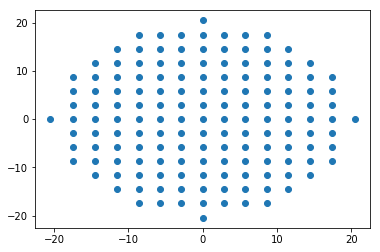

In [23]:
### Angles of illumination ###

max_NA = 0.35 # max NA achievable by illumination
r_led = 7     # radius, in unit of "# of leds"

[NA_x, NA_y] = np.meshgrid(np.linspace(-max_NA, max_NA, 2*r_led+1), np.linspace(-max_NA, max_NA, 2*r_led+1))
NA_x[np.arange(1, NA_x.shape[0], 2), :] = NA_x[np.arange(1, NA_x.shape[0], 2), ::-1] #Flip every other column
#Limit down to a circle
valid_led = (NA_x**2+NA_y**2) <= (max_NA**2)

#NA_x = NA_x[valid_led]
NA_y = NA_y[valid_led]
NA_x = NA_x[valid_led]*-1
#NA_y = NA_y[valid_led][::-1]

angleD_x = np.arcsin(NA_x)*180/np.pi
angleD_y = np.arcsin(NA_y)*180/np.pi

freqUV_design = [angleD_x,angleD_y]
freqUV_design = np.array(freqUV_design)

plt.plot(angleD_x,angleD_y,'o')

In [24]:
# Defining Parameters ###

baseDir = r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\datasets'

datasets_list = [f for f in glob.glob(baseDir + r'\*', recursive=True)] # create list of datasets in 'datasets' folder
outdir = baseDir + r'\results' # output
imgdir = baseDir

useUserNA = True
NA_user = 0.35

#Options
nUsed = 0                   #0=all -1=BF >0, use that # sorted from lowest to highest NA
z0 = 0                      #Defocus amount (um)
tol = 1                     #tol: maximum change of error allowed in two consecutive iterations
#maxIter = 50               #maxIter: maximum iterations 
minIter = 2                 #minIter: minimum iterations
monotone = 5                #monotone (1, default): if monotone, error has to monotonically dropping when iters>minIter
iters = 1                   #Initialize iteration counter
#Display parameters
display = 1                 #display: display results (0: no (default) 1: yes)
mode = 'real'               #mode: display in 'real' space or 'fourier' space
#Propagation type
Prop_mode = 0               #Propagation mode if 0, Fresnel propagation otherwise, angular spectrum
#Regularization & other processing controls
OP_alpha = 10               #OP_alpha: regularization parameter for Object
OP_beta = 1                 #OP_beta: regularization parameter for Pupil
#poscalibrate ='zCal'       #0 #poscalibrate: flag for LED position correction using # '0': no correction # 'sa': simulated annealing method     # 'ga': genetic algorithm
calbratetol = 1e-1          #calbratetol: parameter in controlling error tolerance in sa (simulated annealing)
saveIterResult = False
#Parameters for Zack's calibration
scanRange = 1
radialPenalty = 0 
gradIter = 1
#Parameters for removal of outliers (fitting to a rigid transform)../.
# fitRigidTransform=false
transMethod ='rigidScale'
transAlpha = 2
transScale = 0.5
transTol = 0.05
n_r = 1 
    

In [25]:
### Subtract Background ###

# To use: Run code and double-click on image to pick vertex. To confirm selection, press 'a'.
# Each pair of double-clicks mark opposite vertices of patch. After four selections,
# image will close. Press 'esc' at any time to exit.

# CURRENTLY DOING EVERYTHING W/ 'seq_init_crop' FOLDER IN 'Grant_data'

ix,iy = -1,-1
def return_pos(event,x,y,flags,param):
    global ix,iy
    if event == cv2.EVENT_LBUTTONDBLCLK:
        ix,iy = x,y

def read_cropped(img_path):
    img = cv2.imread(img_path,0)
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', return_pos)
    recs = []
    counter = 0
    while(counter < 4):
        cv2.imshow('image',img)
        k = cv2.waitKey(20)
        if k == 27:                   # to terminate: ASCII 27 is 'esc'.
            break
        elif k == ord('a'):           # PRESS a to confirm vertex selections.
            recs.append([ix,iy])
            counter += 1
    cv2.destroyAllWindows()
    
    return(recs)                      # returns opposite vertices of both rectangles (top left and bottom right).

def select_recs(vert,img_path):       # creates rectangles out of vertices selections.
    rec_1_v = np.array(vert[0:2])
    rec_2_v = np.array(vert[2:4])
    rec_1_v = np.reshape(rec_1_v,(2,2))
    rec_2_v = np.reshape(rec_2_v,(2,2))

    img = cv2.imread(img_path,0)
    crop_img_1 = img[rec_1_v[0][0]:rec_1_v[1][0], rec_1_v[0][1]:rec_1_v[1][1]]
    crop_img_2 = img[rec_2_v[0][0]:rec_2_v[1][0], rec_2_v[0][1]:rec_2_v[1][1]]
    return(np.mean(crop_img_1),np.mean(crop_img_2))

def folder_size(path):               # returns size of folder
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += 1
    return total

seq0_size = folder_size(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller\Grant_data\seq_init_crop')
vertices = read_cropped(I[60])        # choose I[60] just as a sample, can be any image in the seq0_crop directory

thresh = 10                           # background threshold
means_1 = []                          # creates list of means for first rectangles in all images in seq0_crop directory
means_2 = []                          # creates list of means for second rectangles
for i in range(seq0_size):
    y = select_recs(vertices, I[i])
    means_1.append(y[0])
    means_2.append(y[1])

means_1 = np.array(means_1)
means_2 = np.array(means_2)
mean_bg = np.mean((means_1,means_2), axis = 0) # average of both rectangles by column

if mean_bg[0] > thresh:                # if first image mean is above threshold, set the first index as the threshold
    mean_bg[0] = thresh
for i in range(len(mean_bg))[1:]:      # for each image mean, if it is above the threshold, set it to the previous mean value
    if mean_bg[i] > thresh:
        mean_bg[i] = mean_bg[i-1]


for i in range(seq0_size):             # create noise image for each image and subtract, low-pass filter
    img = cv2.imread(I[i],0)
    x = np.zeros((300,300))
    x = [mean_bg[i] for j in x]
    new_img = img - x
    matplotlib.image.imsave(r'C:\Users\Grant\Documents\Internships_Research'+\
                            '\Waller_Lab\waller\Grant_data\seq_init_crop_bg_sub\image_'\
                            +str(i)+'.png', new_img, cmap='gray')
    

In [27]:
# sort everything

NAs_list = np.sqrt((NA_x**2)+(NA_y**2))                        # Create absolute values of NAs
I_bkg = [f for f in glob.glob(r'C:\Users\Grant\Documents\Internships_Research\Waller_Lab\waller'+\
                              '\Grant_data\seq_init_crop_bg_sub\*.png',\
                              recursive=True)]                 # list of images in the sequence
I_sorted = natsort.natsorted(I_bkg)                            # Sort list by integer ('0,1,2,...' not '1,10,100,2,20,...')
I_na_freqUV = []
for i in range(len(I_bkg)):
    I_na_freqUV.append([I_sorted[i],NAs_list[i],\
                        [freqUV_design[0],freqUV_design[1]]])  # Create list of images with corresponding NAs and angles

I_na_freqUV.sort(key=lambda x: x[1])                           # Sort this list smallest to largest according to NAs

images = [I_na_freqUV[i][0] for i in range(len(I_na_freqUV))]  # seperate list into (now ordered by NA) image files, \
NA_A = [I_na_freqUV[i][1] for i in range(len(I_na_freqUV))]    # NA, and angles
angles = [I_na_freqUV[i][2] for i in range(len(I_na_freqUV))]
images = np.array(images)
NA_freqUV = np.array(NA_A)
angles = np.array(angles)


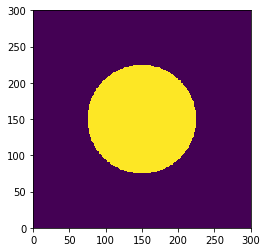

In [28]:
### Create Pupil Function ###

NsampR = np.shape(cropped[0]) # return size of cropped images
NsampR = np.array(NsampR)

z = np.zeros(NsampR)
ci,cj = round(len(z)/2),round(len(z[0])/2)
cr=round(len(z)/4)


I,J = np.meshgrid(np.arange(z.shape[0]),np.arange(z.shape[1]))

dist = np.sqrt((I-ci)**2+(J-cj)**2)

z[np.where(dist<cr)]=1

fig=plt.figure()
ax=fig.add_subplot(111)
ax.pcolormesh(z)
ax.set_aspect('equal')
plt.show()

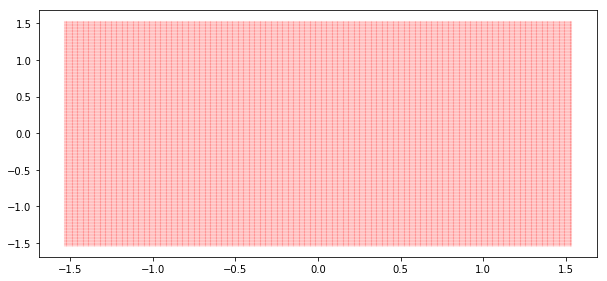

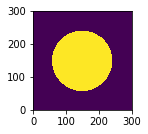

In [29]:
### DEFINE SYSTEM ###

NsampR = np.shape(cropped[0]) # return size of cropped images
NsampR = np.array(NsampR)

uMax = NA_objective/lamb  # Maximum spatial frequency set by NA (1/um)
dxNA = (1/uMax)/2         # System resolution based on the NA (um)
dpix_m = dpix_c/mag       # Effective image pixel size on the object plane (um)
FoV = NsampR*dpix_m       # FoV in the object space

# Sample size in Fourier plane (set by image size (FoV))
du = np.zeros(2)
if NsampR[0] % 2 == 1:   # ROWS
    du[0] = 1/dpix_m/(NsampR[0]-1)
else:
    du[0] = 1/FoV[0]     # sampling size at Fourier plane is always 1/FoV
if NsampR[1] % 2 == 1:   # COLUMNS
    du[1] = 1/dpix_m/(NsampR[1]-1)
else:
    du[1] = 1/FoV[1]

um_idx = uMax/du # max spatial freq/sample size at Fourier plane = # of samples in Fourier space (?). \
                 # I think pixels at Fourier plane?

empty_grid = np.zeros(NsampR) # Create grid size of images

# Maximum spatial frequency achievable based on the maximum illumination
# angle (NAs from NA_freqUV) from the LED array and NA of the objective
um_p = (max(NA_freqUV[:])/lamb) + uMax
# Resolution achieved after frequency post-processing
dx0_p = (1/um_p)/2

# Assume the max spatial frequency of the original object
# um_obj > um_p
# Assume the number of pixels of the original object
# upsample by 2 for intensity (Ask Regina for reason why again)
N_obj = np.around((um_p/du)*2*2) # solving for the number of samples in freq space 

# need to enforce N_obj/Np = integer to ensure no FT artifacts
multiplier = (np.around((N_obj/NsampR)))


### REVISE LATER MULTIPLIER
multiplier = np.array([2,2]) # MULTIPLY BY MINIMUM 2, goal to create larger reconstructed object
N_obj = multiplier*NsampR



# max spatial freq of the original object
um_obj = (du*N_obj/2)

# sampling size of the object (= pixel size of the test image)
dx_obj = (1/um_obj)/2

# setup grid ranges
xxo = (np.arange((-N_obj[1]/2),(N_obj[1]/2)))*dx_obj[1] ### RECONSTRUCTED IMAGE OF OBJECT IN OBJECT PLANE
yyo = (np.arange((-N_obj[0]/2),(N_obj[0]/2)))*dx_obj[0]
xxi = (np.arange((-NsampR[1]/2),(NsampR[1]/2)))*dpix_m  ### IMAGE OF OBJECT IN OBJECT PLANE
yyi = (np.arange((-NsampR[0]/2),(NsampR[0]/2)))*dpix_m
uuo = (np.arange((-N_obj[1]/2),(N_obj[1]/2)))*du[1]
vvo = (np.arange((-N_obj[0]/2),(N_obj[0]/2)))*du[0]
uui = (np.arange((-NsampR[1]/2),(NsampR[1]/2)))*du[1]
vvi = (np.arange((-NsampR[0]/2),(NsampR[0]/2)))*du[0]

# spatial coordinates for object space
xso,yso = np.meshgrid(xxo,yyo)
# spatial coordinates for image space
xsi,ysi = np.meshgrid(xxi,yyi)
dx_img=dpix_m; #sampling size in image (demagnified pixel)

# spatial frequency coordinates for object space
ufo,vfo = np.meshgrid(uuo,vvo)
# spatial frequency coordinates for image space
ufi,vfi = np.meshgrid(uui,vvi)

# Define k-space for these coordinates
ko = np.pi*lamb*(ufo**2+vfo**2)/n_r
ki = np.pi*lamb*(ufi**2+vfi**2)/n_r

# Plot grid to visualize
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(211)
ax.plot(ufo,vfo,marker='.', markersize=0.05, color='r', linestyle='none')
plt.show()

# Generate pupil function
ci,cj = round(len(z)/2),round(len(z[0])/2)
cr=uMax/du[1]
dist = np.sqrt(ufi**2+vfi**2)
pupil = dist < uMax

# PLot pupil function
fig=plt.figure()
ax=fig.add_subplot(221)
ax.pcolormesh(pupil)
ax.set_aspect('equal')
plt.show()



In [30]:
### PTYCHOGRAPHY RECONSTRUCTION ###

# Create images filled with the means of each image for ptych initial guesses
mean_ims = np.average(cropped,axis=0)
mean_ims_rsize = cv2.resize(mean_ims,(600,600))

Ps = pupil
x_obj = xso
y_obj = yso
dpix_mF = (dpix_c/mag)*NsampR[0]/N_obj[0] # Pixel size of new image at sample plane
con=NsampR[0]*dpix_c/mag #Conversion factor (pixels/(1/um)) # FOV
I = cropped

cen0 = np.around((N_obj+1)/2) # Center of reconstructed object

# Initialization

#Fourier & Inverse Fourier Transforms
def F(x):
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(x)))
def Ft(x):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(x)))

maxIter = 5

O0 = np.array(mean_ims_rsize)
Pup = pupil
objR = O0 # Initial reconstructed guess
ObjF = F(objR) # Initial reconstructed guess in Fourier Space
objRsave=np.zeros((maxIter,np.shape(objR)[0],np.shape(objR)[1]),dtype=complex)

err1 = math.inf
err2 = 50
err = np.zeros(maxIter)
iter = 0

### MAIN ###

# stopping criteria: when relative change in error falls below some value,
# can change this value to speed up the process by using a larger value but
# will trade off the reconstruction accuracy. also stops when max iterations
# is surpassed.
# error is defined by the difference between the measurement and the estimated
# images in each iteration.

# Convert from 1/um center to corresponding crop region
# **** Check this conversion
Pupilshifty = np.around(np.array(NA_y)*con) # Converts freq space to # of pixels G
Pupilshiftx = np.around(np.array(NA_x)*con)

# Corresponding crop regions
YXmid = np.floor(N_obj/2)+1
hfSz = np.floor(NsampR[0]/2)
Nimg = len(cropped) # Number of images
cropR = np.zeros((Nimg,4))
cropR[:,0] = YXmid[0] + Pupilshifty - hfSz     # y start
cropR[:,1] = YXmid[0] + Pupilshifty + hfSz - 1 # y end
cropR[:,2] = YXmid[1] + Pupilshiftx - hfSz     # x start
cropR[:,3] = YXmid[1] + Pupilshiftx + hfSz - 1 # x end

# Corresponding to freqUV = (0,0)
cropR_00 = np.array([YXmid[0] - hfSz,     # y start \
                    YXmid[0] + hfSz - 1,  # y end \
                    YXmid[1] - hfSz,      # x start \
                    YXmid[1] + hfSz - 1]) # x end

Objcrop = np.zeros((Nimg, NsampR[0], NsampR[1]),dtype=complex)

now = time.time()
while abs(err1-err2)>tol and iter<maxIter:
    err1 = err2
    err2 = 0
    iter+=1
    
    for i in range(Nimg):
        # Print current image number
        #print('Evaluating image = %s' % str(i))

        I_mea = I[i]
        
        # Perform correction on object reconstruction AND pupil function
        eps = 2.2204460492503131e-16
        row_ind = range(int(cropR[i,0]),int(cropR[i,1])+1)
        col_ind = range(int(cropR[i,2]),int(cropR[i,3])+1)
        Objfcrop = ObjF[np.ix_(row_ind,col_ind)]                                        # Crop out portion of object reconstruction
        ObjfcropP = Objfcrop*Pup                                                        # Apply pupil function
        ObjcropP = Ft(ObjfcropP)           # Exit freq. domain
        Objfup = F((np.sqrt(I_mea))*ObjcropP/((np.abs(ObjcropP+eps)))) # Apply phase (e^(jPHI)) to image (freq. domain)
    
        # Update reconstruction guess and pupil function (gradient descent)
        ObjF[np.ix_(row_ind,col_ind)] = ObjF[np.ix_(row_ind,col_ind)]+((np.abs(Pup))*(np.conj(Pup))*(Objfup-ObjfcropP)/\
                                                                         ((np.max(np.abs(Pup)))*((np.abs(Pup))**2+OP_alpha)))
        Pup = Pup + ((np.abs(Objfcrop))*(np.conj(Objfcrop))*(Objfup-ObjfcropP)*Ps/\
                     ((np.max(np.abs(ObjF)))*((np.abs(Objfcrop))**2+OP_beta)))
        
        Objcrop[i,:,:] = Ft(ObjF[np.ix_(row_ind,col_ind)]*Pup)
        
    print('\n')

    objR = Ft(ObjF)
    objRsave[iter-1,:,:] = objR

    ### COMPUTE ERROR ###
    # Record the error and check convergence later
    err[iter-1] = np.sum((I-(np.abs(Objcrop))**2)**2) # squared error; recall from EE120 Lab 5
    err2 = err[iter-1]
    
    st_iter = str(iter)
    st_err2 = str(err2)
    output = '| %s | %s |'
    print((output % (st_iter,st_err2)),'\n')
    
    
    
elapsed = time.time() - now
print('Time elapsed:', elapsed, 'seconds')



| 1 | 1.9839797302092342e+21 | 



| 2 | 357014992754011.3 | 



| 3 | 278678118667043.44 | 



| 4 | 235557648293241.22 | 



| 5 | 211647056430617.47 | 

Time elapsed: 95.7229356765747 seconds


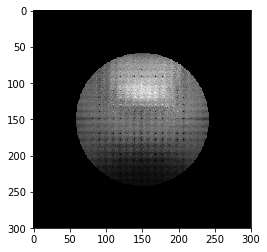

In [31]:
plt.imshow(np.abs(Pup),cmap='gray')

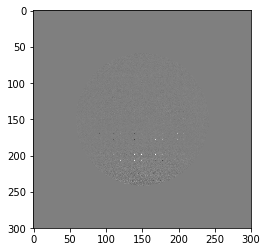

In [32]:
plt.imshow(np.angle(Pup),cmap='gray')

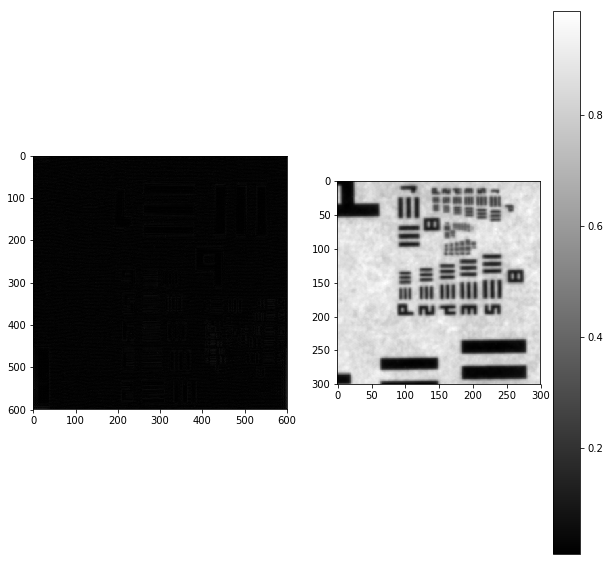

In [33]:
#fig = plt.figure(figsize=(10,10))
#ax1 = fig.add_subplot(121)
#ax1.imshow(np.abs(objR),cmap='gray')
#ax2 = fig.add_subplot(122)
#ax2.imshow(np.abs(actual_obj[300:600,300:600]),cmap='gray')
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.abs(objR),cmap='gray')
plt.subplot(122)
plt.imshow(np.abs(actual_obj[300:600,300:600]),cmap='gray')
plt.colorbar()
